Python version of https://github.com/dflynn-volpe/Interpolate_Weather/

References:

- http://geopandas.org/
- https://github.com/geopandas/scipy2018-geospatial-data/ and [video of tutorial](https://www.youtube.com/watch?v=kJXUUO5M4ok)


Steps:

- Import necessary libraries and set up temporary directory to hold outputs
- Read in data from repository
- Project weather station data and grid shapefile and plot 
- Make raster layer, loop over weather data by day to create interpolated weather layers
- Extract values to grid cells and output data frame of gridded, daily weather values
- Plot raster layer and plot output gridded layers


In [1]:
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Point # to create Point geometry from pandas data frame
import pandas as pd
import os
import requests, zipfile, io
import datetime

# Set up temporary directory to hold outputs
home = os.path.expanduser("~")
temppath = os.path.join(home, "Interpolate_Weather_Temp_py")

#path = os.getcwd()  
#print ("The current working directory is %s" % path) 

if not os.path.exists(temppath):
    print ("Creating %s" % temppath) 
    os.makedirs(temppath)
    
os.chdir(temppath)

In [2]:
wx = pd.read_csv('https://github.com/dflynn-volpe/Interpolate_Weather_Volpe/blob/master/TN_Station_Data_2017-04-01_to_2018-03-31.csv?raw=true')

wx.head()


,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,lat,lon,masl
0,US1TNAN0003,"OAK RIDGE 5.7 NE, TN US",2017-04-01,0.0,0.0,NaN,NaN,NaN,36.0191,-84.2211,270.1
1,US1TNAN0008,"NORRIS 0.6 NW, TN US",2017-04-01,0.0,0.0,NaN,NaN,NaN,36.1997,-84.0765,353.0
2,US1TNAN0009,"OAK RIDGE 5.7 NE, TN US",2017-04-01,0.0,0.0,NaN,NaN,NaN,36.0212,-84.2234,260.3
3,US1TNAN0012,"CLINTON 4.9 S, TN US",2017-04-01,0.0,NaN,NaN,NaN,NaN,36.0199,-84.1255,249.0
4,US1TNBF0004,"BELL BUCKLE 2.0 SE, TN US",2017-04-01,0.0,0.0,NaN,NaN,NaN,35.5698,-86.3291,299.0


In [3]:
# Format date and add a month field  
wx['DATE'] = pd.to_datetime(wx['DATE'])
wx['mo'] = wx['DATE'].dt.month
print(wx.dtypes)
wx.describe()

STATION            object
NAME               object
DATE       datetime64[ns]
PRCP              float64
SNOW              float64
SNWD              float64
TMAX              float64
TMIN              float64
lat               float64
lon               float64
masl              float64
mo                  int64
dtype: object


,PRCP,SNOW,SNWD,TMAX,TMIN,lat,lon,masl,mo
count,153018.000000,93374.000000,45539.000000,50669.000000,50759.000000,159588.000000,159588.000000,159588.000000,159588.000000
mean,0.189733,0.013209,0.048692,69.172038,47.561437,35.864404,-86.162001,277.397736,6.535184
std,0.478147,0.179665,0.411777,17.183518,16.977837,0.436547,1.732109,172.292697,3.417610
min,0.000000,0.000000,0.000000,-3.000000,-8.000000,34.990100,-89.986400,0.000000,1.000000
25%,0.000000,0.000000,0.000000,58.000000,35.000000,35.520800,-87.180500,169.500000,4.000000
50%,0.000000,0.000000,0.000000,73.000000,50.000000,35.939700,-86.400300,237.100000,7.000000
75%,0.130000,0.000000,0.000000,83.000000,62.000000,36.201200,-85.090400,313.900000,9.000000
max,10.200000,9.000000,13.000000,101.000000,80.000000,36.639600,-81.803300,1979.100000,12.000000


In [4]:
r = requests.get('https://github.com/dflynn-volpe/Interpolate_Weather_Volpe/blob/master/TN_01dd_fishnet.zip?raw=true')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(temppath)

with open(os.path.join(temppath, "TN_01dd_fishnet.zip"), "wb") as f: # Optional: writes the zip to disk as well
    f.write(r.content)

# Read in the shapefile
grid_shp = gpd.read_file('TN_01dd_fishnet.shp')
grid_shp.head()

,Shape_Leng,Shape_Area,GRID_ID,GRID_ID_NW,GRID_ID_N,GRID_ID_NE,GRID_ID_W,GRID_ID_E,GRID_ID_SW,GRID_ID_S,GRID_ID_SE,geometry
0,0.4,0.01,1,None,None,62,None,2,None,None,None,POLYGON ((-90.32000000019195 34.98000000013764...
1,0.4,0.01,2,None,62,63,1,3,None,None,None,"POLYGON ((-90.2199999995326 34.98000000013764,..."
2,0.4,0.01,3,62,63,64,2,4,None,None,None,POLYGON ((-90.12000000019037 34.98000000013764...
3,0.4,0.01,4,63,64,65,3,5,None,None,None,POLYGON ((-90.01999999953102 34.98000000013764...
4,0.4,0.01,5,64,65,66,4,6,None,None,None,POLYGON ((-89.92000000018879 34.98000000013764...


{'init': 'epsg:4269'}


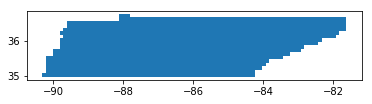

In [5]:
print(grid_shp.crs)
grid_shp.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0


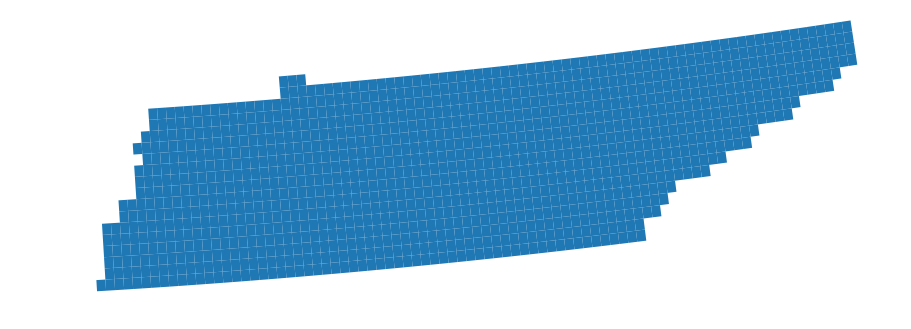

In [6]:
# Project the point and grid data. Remember to use _ and not . in variable names
proj_USGS = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"
# EPSG for this Albers Equal Area projection, https://epsg.io/102008

print(type(grid_shp))
# Options for AEA projection: EPSG codes for https://epsg.io/102003 don't work for some reason, but full proj4 string does
# grid_shp2 = grid_shp.to_crs({'init': 'epsg:2163'}) # works, but not the projection we want
# grid_shp2 = grid_shp.to_crs({'init': 'epsg:102003'}) # fails... ?? https://epsg.io/102003
# Next one works
# grid_shp2 = grid_shp.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0")
grid_shp = grid_shp.to_crs(proj_USGS) # Also works

print(grid_shp.crs)
ax = grid_shp.plot(figsize = (15,15))
ax.set_axis_off()

In [7]:
# Now also project weather data and overplot
geometry = [Point(xy) for xy in zip(wx.lon, wx.lat)] # Make the shapely geometry Points from lat long
# wx = wx.drop(['lon', 'lat'], axis=1) # Some recommend removing these from the DataFrame, but convenient to keep for making aggregates
crs = {'init': 'epsg:4326'} # Define decimal degree lat long
wx = gpd.GeoDataFrame(wx, crs=crs, geometry=geometry) # Create GeoDataFrame

wx = wx.to_crs(proj_USGS) # Re-project

In [12]:
# Make a DataFrame for June averages from the GeoDataFrame
wx_june = wx[wx['mo']==6]
wx_june_mean = wx_june.groupby(wx_june['STATION'])['lat','lon','PRCP','SNOW','SNWD','TMAX','TMIN'].mean()

# We need to project this summary DataFrame as well to make it into a GeoDataFrame
geometry = [Point(xy) for xy in zip(wx_june_mean.lon, wx_june_mean.lat)] 
crs = {'init': 'epsg:4326'} # Define decimal degree lat long
wx_june_mean = gpd.GeoDataFrame(wx_june_mean, crs=crs, geometry=geometry) # Create GeoDataFrame

wx_june_mean = wx_june_mean.to_crs(proj_USGS) # Re-project

print(type(wx_june_mean)) # Check to see this is a GeoDataFrame
wx_june_mean.describe()

<class 'geopandas.geodataframe.GeoDataFrame'>


,lat,lon,PRCP,SNOW,SNWD,TMAX,TMIN
count,509.000000,509.000000,495.000000,433.0,142.0,143.000000,143.000000
mean,35.867108,-86.184802,0.198615,0.0,0.0,83.274207,62.060108
std,0.437892,1.710027,0.186903,0.0,0.0,3.244591,3.210906
min,34.990100,-89.986400,0.000000,0.0,0.0,62.400000,45.866667
25%,35.524700,-87.136400,0.120333,0.0,0.0,81.966667,60.331818
50%,35.935000,-86.423800,0.154400,0.0,0.0,83.733333,62.533333
75%,36.201200,-85.134400,0.203333,0.0,0.0,85.133333,64.250000
max,36.639600,-81.803300,1.846667,0.0,0.0,88.666667,69.500000


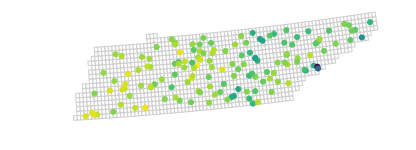

In [42]:
# plot some points. matplot requries dropping the NA values with .dropna()
# Not sure why can't get the figure size larger. Ignores figsize=() arguments

ax = grid_shp.plot(facecolor='w', edgecolor='50')

tempplot = wx_june_mean.dropna(subset=['TMAX']).plot(figsize=(15,15), ax=ax, column='TMAX', markersize=25).set_axis_off()


In [45]:
# Same, for sum of precipitation. Here we have to join back to previous wx table to get lat long, to do
wx_june_sum = wx_june.groupby(wx_june['STATION'])['PRCP','SNOW','SNWD'].sum()

wx_june_sum.describe()

,PRCP,SNOW,SNWD
count,509.000000,509.0,509.0
mean,4.108468,0.0,0.0
std,1.794169,0.0,0.0
min,0.000000,0.0,0.0
25%,3.020000,0.0,0.0
50%,4.170000,0.0,0.0
75%,5.150000,0.0,0.0
max,9.870000,0.0,0.0
